# Radon-Transform (CPU)

## Setup

In [1]:
from math import sin, cos
import typing
import torch
import torchvision
import matplotlib.pyplot as plt
import torch_radon
import radon
#rm -r ~/.cache/torch_extensions/py310_cu116/*
#BUG "/usr/include/c++/11/bits/std_function.h:435:145: error: parameter packs not expanded with ‘...’" --> https://github.com/NVIDIA/nccl/issues/650#issuecomment-1145173577

In [2]:
def shepp_logan_phantom(n):
    phantom = torch.zeros((n,n))
    centers = torch.tensor([[0, 0], [0, -0.0184], [0.11, 0], [-0.11, 0], [0, 0.175], [0, 0.05], [0, -0.05], [-0.04, -0.3025], [0, -0.3025], [0.03, -0.3025]])
    axes = torch.tensor([[0.69, 0.92], [0.6624, 0.874], [0.11, 0.31], [0.16, 0.41], [0.21, 0.25], [0.046, 0.046], [0.046, 0.046], [0.046, 0.023], [0.023, 0.023], [0.023, 0.046]])
    theta = torch.tensor([0, 0, -0.31415926535, 0.31415926535, 0, 0, 0, 0, 0, 0])
    intensity = torch.tensor([2, -1.0, -0.2, -0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
    x,y = torch.meshgrid(torch.linspace(-0.5, 0.5, n), -torch.linspace(-0.5, 0.5, n), indexing="ij")
    with torch.no_grad():
        for i in range(10):
            phantom[
                torch.square((x-centers[i,0])*cos(theta[i])+(y-centers[i,1])*sin(theta[i]))/((axes[i,0]/2.0)**2)+
                torch.square((x-centers[i,0])*sin(theta[i])-(y-centers[i,1])*cos(theta[i]))/((axes[i,1]/2.0)**2)
                <= 1.0] += intensity[i]
    return phantom.T

## Examples

### Python functions

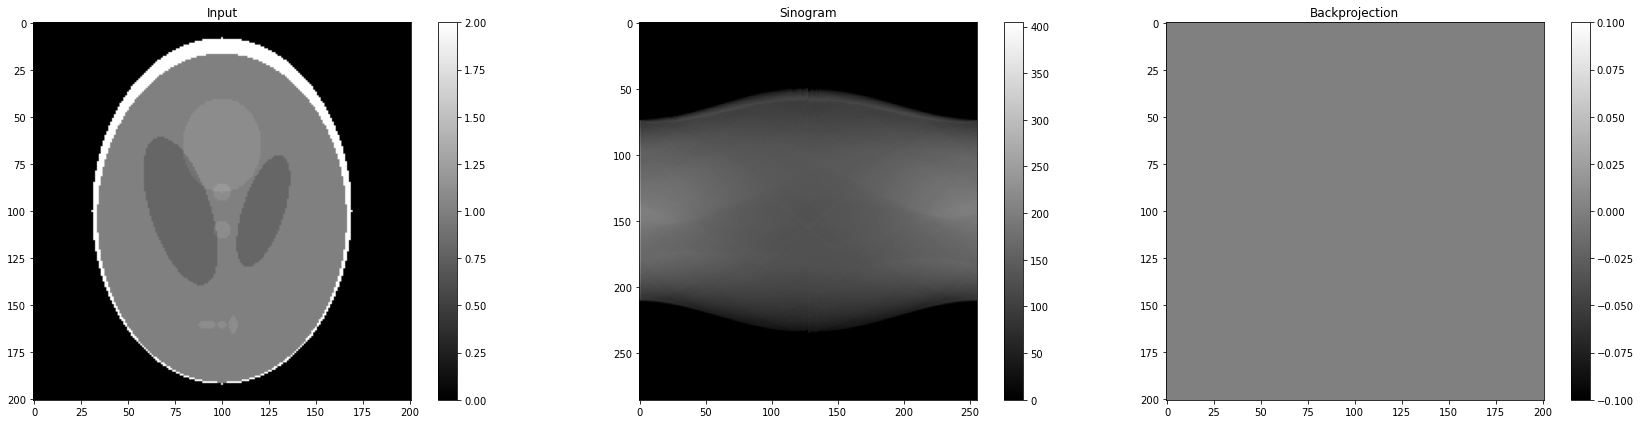

In [3]:
img0 = shepp_logan_phantom(201).contiguous().unsqueeze(0).unsqueeze(0).requires_grad_(True)
#img0 = next(iter(torchvision.datasets.MNIST("/data/datasets/", True, torchvision.transforms.ToTensor(), download=True)))[0].unsqueeze(0).requires_grad_(True)
plt.subplots(1, 3, figsize=(24,6))
plt.subplot(1, 3, 1)
plt.title("Input")
plt.imshow(img0[0,0].detach(), cmap="gray")
plt.colorbar()
sino0 = radon.radon_forward(img0)
plt.subplot(1, 3, 2)
plt.title("Sinogram")
plt.imshow(sino0[0,0].detach().mT, cmap="gray")
plt.colorbar()
recon0 = radon.radon_backward(sino0, img0.shape[3])
plt.subplot(1, 3, 3)
plt.title("Backprojection")
plt.imshow(recon0[0,0].detach(), cmap="gray")
plt.colorbar()
plt.tight_layout()
plt.show()

### Torch-Autograd-Function

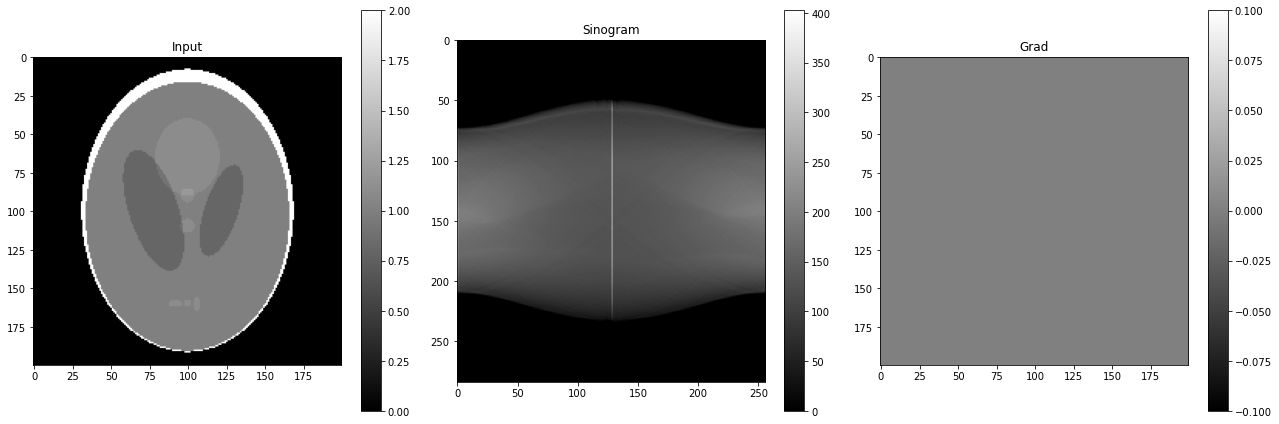

In [4]:
img1 = shepp_logan_phantom(200).contiguous().unsqueeze(0).unsqueeze(0).requires_grad_(True)
#img1 = next(iter(torchvision.datasets.MNIST("/data/datasets/", True, torchvision.transforms.ToTensor(), download=True)))[0].unsqueeze(0).requires_grad_(True)
plt.subplots(1, 3, figsize=(18,6))
plt.subplot(1, 3, 1)
plt.title("Input")
plt.imshow(img1[0,0].detach(), cmap="gray")
plt.colorbar()
sino1 = radon.RadonTransformFunc.apply(img1, torch.linspace(0, 3.14159265359, 257)[:-1])
plt.subplot(1, 3, 2)
plt.title("Sinogram")
plt.imshow(sino1[0,0].detach().mT, cmap="gray")
plt.colorbar()
sino1.sum().backward()
recon1 = typing.cast(torch.Tensor, img1.grad)
plt.subplot(1, 3, 3)
plt.title("Grad")
plt.imshow(recon1[0,0].detach(), cmap="gray")
plt.colorbar()
plt.tight_layout()
plt.show()

### Torch-Module

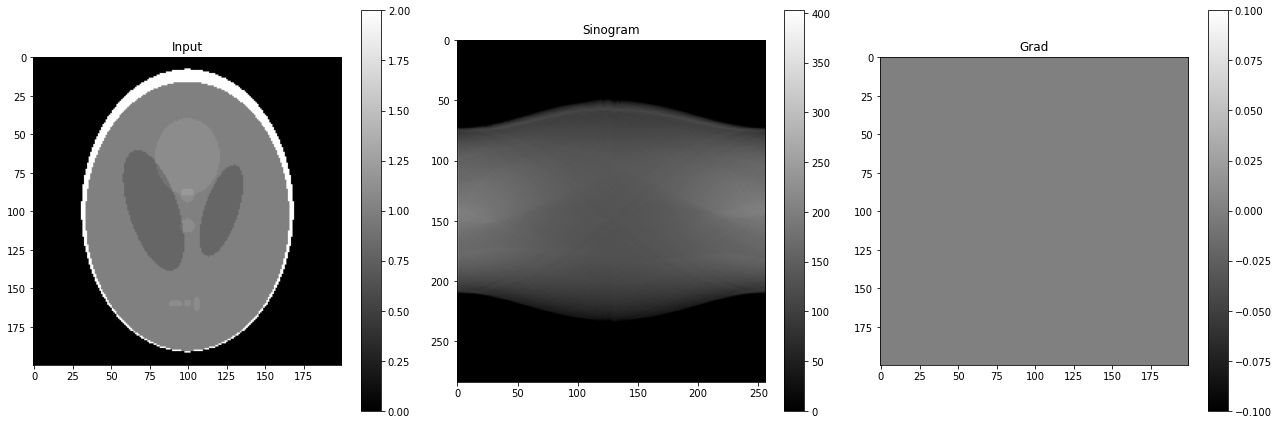

In [5]:
radon_trans = radon.RadonTransform()
img2 = shepp_logan_phantom(200).contiguous().unsqueeze(0).unsqueeze(0).requires_grad_(True)
#img1 = next(iter(torchvision.datasets.MNIST("/data/datasets/", True, torchvision.transforms.ToTensor(), download=True)))[0].unsqueeze(0).requires_grad_(True)
plt.subplots(1, 3, figsize=(18,6))
plt.subplot(1, 3, 1)
plt.title("Input")
plt.imshow(img2[0,0].detach(), cmap="gray")
plt.colorbar()
sino2 = radon_trans(img2)
plt.subplot(1, 3, 2)
plt.title("Sinogram")
plt.imshow(sino2[0,0].detach().mT, cmap="gray")
plt.colorbar()
sino2.sum().backward()
recon2 = typing.cast(torch.Tensor, img2.grad)
plt.subplot(1, 3, 3)
plt.title("Grad")
plt.imshow(recon2[0,0].detach(), cmap="gray")
plt.colorbar()
plt.tight_layout()
plt.show()

## Debug

### Torch-Radon

RuntimeError: x must be a CUDA tensor
Exception raised from radon_forward at /home/alexander/torch-radon/src/pytorch.cpp:17 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x57 (0x7f95b14b4497 in /home/alexander/anaconda3/envs/FSDLIP/lib/python3.10/site-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, char const*) + 0x68 (0x7f95b148bd5d in /home/alexander/anaconda3/envs/FSDLIP/lib/python3.10/site-packages/torch/lib/libc10.so)
frame #2: radon_forward(at::Tensor, at::Tensor, Cache<DeviceSizeKey, Texture>&, RaysCfg) + 0x22f (0x7f95168535ef in /home/alexander/anaconda3/envs/FSDLIP/lib/python3.10/site-packages/torch_radon-1.0.0-py3.10-linux-x86_64.egg/torch_radon_cuda.cpython-310-x86_64-linux-gnu.so)
frame #3: <unknown function> + 0x23df8 (0x7f9516867df8 in /home/alexander/anaconda3/envs/FSDLIP/lib/python3.10/site-packages/torch_radon-1.0.0-py3.10-linux-x86_64.egg/torch_radon_cuda.cpython-310-x86_64-linux-gnu.so)
frame #4: <unknown function> + 0x216c6 (0x7f95168656c6 in /home/alexander/anaconda3/envs/FSDLIP/lib/python3.10/site-packages/torch_radon-1.0.0-py3.10-linux-x86_64.egg/torch_radon_cuda.cpython-310-x86_64-linux-gnu.so)
frame #5: <unknown function> + 0x17ffa4 (0x55c43a75ffa4 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #6: _PyObject_MakeTpCall + 0x15e (0x55c43a72252e in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #7: _PyEval_EvalFrameDefault + 0x4ce5 (0x55c43a7c5d75 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #8: <unknown function> + 0x18f742 (0x55c43a76f742 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #9: _PyObject_Call + 0x20a (0x55c43a727faa in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #10: THPFunction_apply(_object*, _object*) + 0x5d6 (0x7f956e48c8c6 in /home/alexander/anaconda3/envs/FSDLIP/lib/python3.10/site-packages/torch/lib/libtorch_python.so)
frame #11: <unknown function> + 0x17ffc8 (0x55c43a75ffc8 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #12: _PyObject_MakeTpCall + 0x15e (0x55c43a72252e in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #13: _PyEval_EvalFrameDefault + 0x4ce5 (0x55c43a7c5d75 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #14: <unknown function> + 0x18f742 (0x55c43a76f742 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #15: _PyObject_Call + 0x20a (0x55c43a727faa in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #16: _PyEval_EvalFrameDefault + 0x26e4 (0x55c43a7c3774 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #17: <unknown function> + 0x18f742 (0x55c43a76f742 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #18: <unknown function> + 0x1049f3 (0x55c43a6e49f3 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #19: <unknown function> + 0x18f742 (0x55c43a76f742 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #20: PyEval_EvalCode + 0x88 (0x55c43a77e578 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #21: <unknown function> + 0x292b1a (0x55c43a872b1a in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #22: <unknown function> + 0x14ca61 (0x55c43a72ca61 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #23: <unknown function> + 0x104425 (0x55c43a6e4425 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #24: <unknown function> + 0x192a06 (0x55c43a772a06 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #25: PyIter_Send + 0x3b7 (0x55c43a7762e7 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #26: _PyEval_EvalFrameDefault + 0x1d3a (0x55c43a7c2dca in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #27: <unknown function> + 0x192a06 (0x55c43a772a06 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #28: PyIter_Send + 0x3b7 (0x55c43a7762e7 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #29: _PyEval_EvalFrameDefault + 0x1d3a (0x55c43a7c2dca in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #30: <unknown function> + 0x192a06 (0x55c43a772a06 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #31: <unknown function> + 0x24a9a8 (0x55c43a82a9a8 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #32: <unknown function> + 0x14ada4 (0x55c43a72ada4 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #33: <unknown function> + 0x1049f3 (0x55c43a6e49f3 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #34: <unknown function> + 0x18f742 (0x55c43a76f742 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #35: <unknown function> + 0x104425 (0x55c43a6e4425 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #36: <unknown function> + 0x18f742 (0x55c43a76f742 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #37: <unknown function> + 0x1049f3 (0x55c43a6e49f3 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #38: <unknown function> + 0x18f742 (0x55c43a76f742 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #39: <unknown function> + 0x18fc9b (0x55c43a76fc9b in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #40: _PyObject_Call + 0x29b (0x55c43a72803b in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #41: _PyEval_EvalFrameDefault + 0x26e4 (0x55c43a7c3774 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #42: <unknown function> + 0x18f742 (0x55c43a76f742 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #43: <unknown function> + 0x18fc9b (0x55c43a76fc9b in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #44: <unknown function> + 0x1050b5 (0x55c43a6e50b5 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #45: <unknown function> + 0x192a06 (0x55c43a772a06 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #46: PyIter_Send + 0x3b7 (0x55c43a7762e7 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #47: _PyEval_EvalFrameDefault + 0x1d3a (0x55c43a7c2dca in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #48: <unknown function> + 0x192a06 (0x55c43a772a06 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #49: PyIter_Send + 0x3b7 (0x55c43a7762e7 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #50: _PyEval_EvalFrameDefault + 0x1d3a (0x55c43a7c2dca in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #51: <unknown function> + 0x192a06 (0x55c43a772a06 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #52: PyIter_Send + 0x3b7 (0x55c43a7762e7 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #53: _PyEval_EvalFrameDefault + 0x1d3a (0x55c43a7c2dca in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #54: <unknown function> + 0x192a06 (0x55c43a772a06 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #55: PyIter_Send + 0x3b7 (0x55c43a7762e7 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #56: _PyEval_EvalFrameDefault + 0x1d3a (0x55c43a7c2dca in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #57: <unknown function> + 0x192a06 (0x55c43a772a06 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #58: PyIter_Send + 0x3b7 (0x55c43a7762e7 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #59: <unknown function> + 0x7845 (0x7f95ce376845 in /home/alexander/anaconda3/envs/FSDLIP/lib/python3.10/lib-dynload/_asyncio.cpython-310-x86_64-linux-gnu.so)
frame #60: <unknown function> + 0x80cb (0x7f95ce3770cb in /home/alexander/anaconda3/envs/FSDLIP/lib/python3.10/lib-dynload/_asyncio.cpython-310-x86_64-linux-gnu.so)
frame #61: <unknown function> + 0x14c8eb (0x55c43a72c8eb in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #62: <unknown function> + 0x78a51 (0x55c43a658a51 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)
frame #63: <unknown function> + 0xa0399 (0x55c43a680399 in /home/alexander/anaconda3/envs/FSDLIP/bin/python)


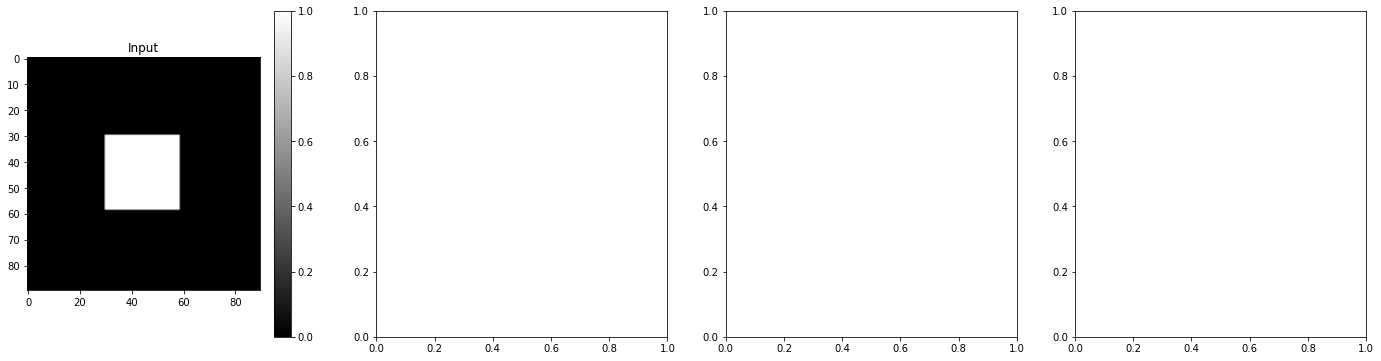

In [6]:
torchradon = torch_radon.Radon(90, torch.linspace(0.0, 3.14159265359, 256), 90, 1)
img3 = torch.zeros((1,1,90,90))
img3[0, 0, 30:59,30:59] = 1.0
img3.requires_grad = True
plt.subplots(1, 4, figsize=(24,6))
plt.subplot(1, 4, 1)
plt.title("Input")
plt.imshow(img3.detach()[0,0], cmap="gray")
plt.colorbar()
sino3 = torchradon.forward(img3)
plt.subplot(1, 4, 2)
plt.title("Sinogram")
plt.imshow(sino3.detach()[0,0], cmap="gray")
plt.colorbar()
recon3 = torchradon.backward(sino3)
plt.subplot(1, 4, 3)
plt.title("Backprojection")
plt.imshow(recon3.detach()[0,0], cmap="gray")
plt.colorbar()
sino3.sum().backward()
plt.subplot(1, 4, 4)
plt.title("Grad")
plt.imshow(typing.cast(torch.Tensor, img3.grad).detach()[0,0], cmap="gray")
plt.colorbar()
plt.tight_layout()
plt.show()

### Ours

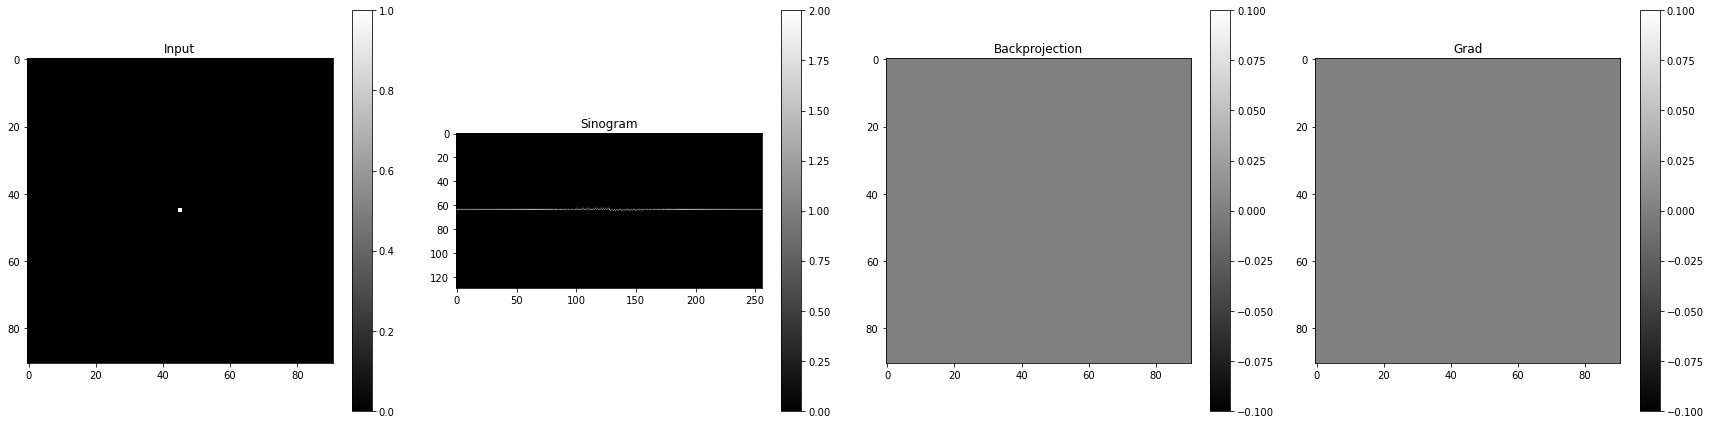

In [14]:
img4 = torch.zeros((1,1,91,91))
#img4[0, 0, 30:59,30:59] = 1.0
img4[0, 0, 30, 30] = 1.0
plt.subplots(1, 4, figsize=(24,6))
plt.subplot(1, 4, 1)
plt.title("Input")
plt.imshow(img4[0,0], cmap="gray")
plt.colorbar()
sino4 = radon.RadonTransformFunc.apply(img4, torch.linspace(0, 3.14159265359, 257)[:-1])
plt.subplot(1, 4, 2)
plt.title("Sinogram")
plt.imshow(sino4[0,0].mT, cmap="gray")
plt.colorbar()
recon4 = radon.radon_backward(sino4, img4.shape[3])
plt.subplot(1, 4, 3)
plt.title("Backprojection")
plt.imshow(recon4[0,0], cmap="gray")
plt.colorbar()
img4.requires_grad = True
radon.RadonTransformFunc.apply(img4, torch.linspace(0, 3.14159265359, 257)[:-1]).sum().backward()
plt.subplot(1, 4, 4)
plt.title("Grad")
plt.imshow(typing.cast(torch.Tensor, img4.grad).detach()[0,0], cmap="gray")
plt.colorbar()
plt.tight_layout()
plt.show()

### Difference

NameError: name 'sino3' is not defined

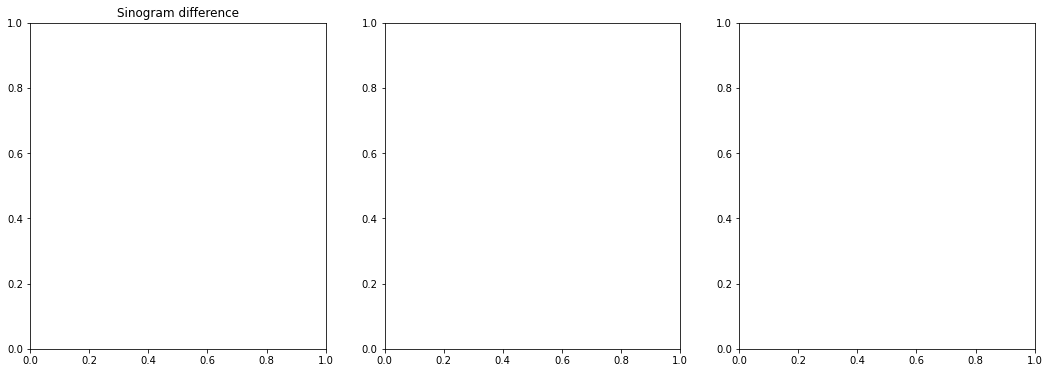

In [8]:
plt.subplots(1, 3, figsize=(18,6))
plt.subplot(1, 3, 1)
plt.title("Sinogram difference")
plt.imshow((sino4[0,0]-sino3.detach()[0,0]).mT, cmap="gray")
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title("Backprojection difference")
plt.imshow((recon4[0,0]-recon3.detach()[0,0]), cmap="gray")
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title("Grad difference")
plt.imshow((typing.cast(torch.Tensor, img4.grad).detach()[0,0]-typing.cast(torch.Tensor, img3.grad).detach().detach()[0,0]), cmap="gray")
plt.colorbar()
plt.tight_layout()
plt.show()